In [3]:
!pip install scikit-learn

In [5]:
pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/a4/7d/f1c30a92854540bf789e9cd5dde7ef49bbe63f855b85a2e6b3db8135c591/opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB 653.6 kB/s eta 0:01:01
   -- ------------------------------------- 2.6/39.5 MB 28.1 MB/s eta 0:00:02
   --- ------------------------------------ 3.4/39.5 MB 24.1 MB/s eta 0:00:02
   --- ------------------------------------ 3.9/39.5 MB 20.6 MB/s eta 0:00:02
   ---- ----------------------------------- 4.3/39.5 MB 18.2 MB/s eta 0:00:02
   ---- ----------------------------------- 4.7/39.5 MB 16.7 MB/s eta 0:00:03
   ----- ---------------------------------- 5.1/39.5 MB 15.6 MB/s eta 0:00:03
   ----- ---------------------------------- 5.6/39.5 MB 14.9 MB/s eta 0:00:03
   ------ --------------------------------- 6.1/39.5 MB 14.4 MB/s eta 0:00:03
   --

In [136]:
!pip install ttkthemes

     ---------------------------------------- 0.0/891.2 kB ? eta -:--:--
      ------------------------------------ 20.5/891.2 kB 330.3 kB/s eta 0:00:03
     - ----------------------------------- 30.7/891.2 kB 435.7 kB/s eta 0:00:02
     --- --------------------------------- 81.9/891.2 kB 573.4 kB/s eta 0:00:02
     -------------------------------------  890.9/891.2 kB 5.1 MB/s eta 0:00:01
     -------------------------------------- 891.2/891.2 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ttkthemes: filename=ttkthemes-3.2.2-cp311-cp311-win_amd64.whl size=1794008 sha256=0b7f6b6f291cb7fd7b6a1d98a59caa12153c1dbdb4ecaf884f25ad1d9b768c1c
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\3e\6a\7a\32b372ddd40d19d476793521c693b2c0db7cfdcaff1c39ce2b
Successfully built ttkthemes


In [29]:
!pip install pytesseract

  Obtaining dependency information for pytesseract from https://files.pythonhosted.org/packages/7a/33/8312d7ce74670c9d39a532b2c246a853861120486be9443eebf048043637/pytesseract-0.3.13-py3-none-any.whl.metadata


In [1]:
import cv2
import numpy as np
import pandas as pd
import networkx as nx
import tkinter as tk
from tkinter import filedialog, Label, Button
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tkinter import Frame
from ttkthemes import ThemedTk
from tkinter import ttk
import tkinter as tk
import re

In [36]:
import cv2
import numpy as np
import pytesseract

def estimate_pixel_to_um(image_path):
    """
    解析圖片中的比例尺資訊（OCR + 傳統方法），無法識別則使用預設值。
    """
    default_pixel_to_um = 0.01
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"❌ 無法加載圖片: {image_path}")

    # OCR 讀取比例尺數值
    roi = img[-50:, :]  # 取圖片底部
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray, config="--psm 6")
    
    # 嘗試解析 OCR 結果
    import re
    match = re.search(r"([\d.]+)\s*(µm|nm|mm)", text, re.IGNORECASE)
    if match:
        scale_bar_length = float(match.group(1))
        unit = match.group(2).lower()
        if unit == "nm":
            scale_bar_length /= 1000  # 轉換成 µm
        elif unit == "mm":
            scale_bar_length *= 1000  # 轉換成 µm
        return scale_bar_length / img.shape[1]  # 計算 µm/px

    print("❌ 無法解析比例尺，使用預設 1:1")
    return default_pixel_to_um


In [3]:
# 使用 Otsu + 形态学处理进行图像分割
def segment_image_otsu(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"图像未能正确加载，请检查文件路径或格式: {image_path}")
    
    # Otsu 阈值法
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 形态学操作 - 去除噪声
    kernel = np.ones((3,3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    binary = cv2.dilate(binary, kernel, iterations=1)
    
    # Canny 边缘检测
    edges = cv2.Canny(binary, 100, 200)
    return edges, binary

In [4]:
# 预处理图像并检测颗粒
def detect_particles(image_path, pixel_to_um):
    edges, binary = segment_image_otsu(image_path)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    particle_data = []
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] > 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            area_px = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            circularity = 4 * np.pi * area_px / (perimeter ** 2) if perimeter > 0 else 0
            area_um = area_px * (pixel_to_um ** 2)
            centroids.append((cx, cy))
            particle_data.append((cx, cy, area_um, circularity))
    return centroids, particle_data, binary

In [5]:
import math  # 如果尚未引用 math 模組，請加上這一行

def detect_tpb_points_improved(centroids, pixel_to_um, threshold_um=0.5, angle_threshold=30):
    """
    改進版的 TPB 檢測函式：
      - 根據距離閥值建立鄰近關係。
      - 對每個與至少兩個鄰居連接的節點，計算從該節點指向每個鄰居的向量，
        並計算所有向量之間的夾角，以最小夾角作為可信度依據。
    
    參數：
      centroids: list of (x, y) 粒子質心
      pixel_to_um: 每個像素代表多少 µm
      threshold_um: 鄰近距離閥值，預設 0.5 µm
      angle_threshold: 角度過濾閥值，低於此值則可信度為 0（單位：度）
    
    回傳：
      tpb_points: 檢測到的 TPB 點列表
      confidence_scores: 每個 TPB 點對應的可信度分數（0～1）
    """
    threshold_px = threshold_um / pixel_to_um
    G = nx.Graph()
    
    # 建立鄰近關係，僅比較一次 (i < j)
    for i, (x1, y1) in enumerate(centroids):
        for j, (x2, y2) in enumerate(centroids):
            if i < j:
                distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                if distance < threshold_px:
                    G.add_edge(i, j)
    
    tpb_points = []
    confidence_scores = []
    for node in G.nodes:
        neighbors = list(G[node])
        if len(neighbors) >= 2:
            x0, y0 = centroids[node]
            vectors = []
            for n in neighbors:
                xn, yn = centroids[n]
                dx, dy = xn - x0, yn - y0
                norm = math.hypot(dx, dy)
                if norm > 0:
                    vectors.append((dx / norm, dy / norm))
            if len(vectors) < 2:
                continue
            
            angles = []
            for i in range(len(vectors)):
                for j in range(i+1, len(vectors)):
                    dot = np.clip(vectors[i][0] * vectors[j][0] + vectors[i][1] * vectors[j][1], -1.0, 1.0)
                    angle = math.degrees(math.acos(dot))
                    angles.append(angle)
            
            if angles:
                min_angle = min(angles)
                if min_angle < angle_threshold:
                    conf = 0.0
                else:
                    conf = min_angle / 90.0
                    conf = max(0.0, min(conf, 1.0))
                
                tpb_points.append(centroids[node])
                confidence_scores.append(conf)
    
    return tpb_points, confidence_scores


In [6]:
# 可视化 TPB 结果
def visualize_tpb(image_path, centroids, tpb_points):
    img = cv2.imread(image_path)
    for (cx, cy) in centroids:
        cv2.circle(img, (cx, cy), 3, (0, 255, 0), -1)  # 绿色标记颗粒
    for (tx, ty) in tpb_points:
        cv2.circle(img, (tx, ty), 3, (0, 0, 255), -1)  # 红色标记 TPB
    output_path = "tpb_output.png"
    cv2.imwrite(output_path, img)
    return output_path

In [7]:
# 计算 TPB 密度
def calculate_tpb_density(tpb_points, image_shape, pixel_to_um):
    img_area_um2 = (image_shape[0] * pixel_to_um) * (image_shape[1] * pixel_to_um)
    unit_count = img_area_um2 / 10
    tpb_density = len(tpb_points) / unit_count if unit_count > 0 else 0
    return tpb_density

In [8]:
# 保存数据到CSV
def save_tpb_data (particle_data, tpb_points):
    df = pd.DataFrame(particle_data, columns=["Centroid_X", "Centroid_Y", "Area_um2", "Circularity"])
    df_tpb = pd.DataFrame(tpb_points, columns=["TPB_X", "TPB_Y"])
    df.to_csv("particles.csv", index=False)
    df_tpb.to_csv("tpb_points.csv", index=False)

In [9]:
def plot_confidence_histogram(confidence_scores):
    """
    绘制候选 TPB 点可信度分布直方图，并返回 matplotlib 的 Figure 对象。
    
    参数：
      confidence_scores: list, 每个候选 TPB 点的可信度分数，值介于 0 到 1 之间。
      
    返回：
      fig: matplotlib.figure.Figure 对象，可以用于进一步嵌入到 GUI 中显示。
    """
    import matplotlib.pyplot as plt  # 如果你还没有导入 matplotlib，请确保这里导入
    # 创建一个大小为 4x3 英寸的图形
    fig, ax = plt.subplots(figsize=(4, 3))
    # 绘制直方图，设定 10 个箱子，范围为 0 到 1，边框颜色为黑色
    ax.hist(confidence_scores, bins=10, range=(0, 1), edgecolor='black')
    # 设置图形标题和坐标轴标签
    ax.set_title("TPB 点可信度分布")
    ax.set_xlabel("可信度")
    ax.set_ylabel("点的数量")
    # 设置 x 轴刻度
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    return fig


In [10]:
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import ttk  # 用于进度条
from PIL import Image, ImageTk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import cv2
import numpy as np

# 全局变量，用于在页面间传递数据
last_result_str = ""
last_processed_img_tk = None
last_original_img_tk = None
last_conf_scores = None
last_shape_counts = None

In [11]:
def plot_confidence_histogram(confidence_scores):
    """
    绘制 TPB confidence distribution 直方图。
      - 标题: "TPB confidence distribution"
      - X 轴: Confidence score
      - Y 轴: Number of TPB candidates
    """
    import matplotlib.pyplot as plt  # 确保 matplotlib 已导入
    fig, ax = plt.subplots(figsize=(4,4))
    ax.hist(confidence_scores, bins=10, range=(0,1), edgecolor='black')
    ax.set_title("TPB confidence distribution", fontdict={'fontsize':14, 'fontweight':'bold'})
    ax.set_xlabel("Confidence score", fontsize=12)
    ax.set_ylabel("Number of TPB candidates", fontsize=12)
    ax.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
    return fig

def show_progress_overlay(duration=3000, tip_text="Tips: Use a clear, high-resolution image for better analysis results.", bg_color="lightgray", alpha=1.0):
    """
    创建一个 Toplevel 窗口作为覆盖层，显示进度条和提示信息。
    duration: 显示时长（毫秒）
    tip_text: 显示的提示文字
    bg_color: 背景颜色（例如 "lightgray"）
    alpha: 窗口透明度（1.0 为完全不透明）
    该覆盖层会完全覆盖主窗口的内容，并在 duration 毫秒后自动销毁。
    """
    root.update_idletasks()  # 确保根窗口尺寸更新
    overlay = tk.Toplevel(root)
    overlay.overrideredirect(True)  # 去掉窗口边框
    overlay.geometry(f"{root.winfo_width()}x{root.winfo_height()}+{root.winfo_rootx()}+{root.winfo_rooty()}")
    overlay.configure(bg=bg_color)
    overlay.attributes("-alpha", alpha)
    container = tk.Frame(overlay, bg=bg_color)
    container.place(relx=0.5, rely=0.5, anchor="center")
    progress = ttk.Progressbar(container, mode="indeterminate", length=200)
    progress.pack()
    progress.start()
    tip_label = tk.Label(container, text=tip_text, font=("Arial", 10), bg=bg_color)
    tip_label.pack(pady=5)
    overlay.after(duration, overlay.destroy)
    return overlay, progress

def hide_progress_bar(progress_frame, progress):
    """停止并销毁进度条控件（如有）。"""
    try:
        if progress.winfo_exists():
            progress.stop()
    except Exception as e:
        print("Error stopping progress bar:", e)
    try:
        if progress_frame.winfo_exists():
            progress_frame.destroy()
    except Exception as e:
        print("Error destroying progress frame:", e)


In [47]:
from PIL import Image, ImageTk  # ✅ 修正 ImportError，移除 ImageResampling

# 調整後的 AutoResizeImageLabel
class AutoResizeImageLabel(tk.Label):
    def __init__(self, master, pil_image, fixed_height=None, **kwargs):
        super().__init__(master, **kwargs)
        self.original_image = pil_image
        self.fixed_height = fixed_height
        self.current_size = None
        self.bind("<Configure>", self._resize_image)

    def _resize_image(self, event):
        if self.fixed_height is not None:
            new_height = self.fixed_height
            scale = new_height / self.original_image.size[1]
            new_width = int(self.original_image.size[0] * scale)
        else:
            container_width = event.width
            container_height = event.height
            orig_width, orig_height = self.original_image.size
            scale = min(container_width / orig_width, container_height / orig_height)
            new_width = int(orig_width * scale)
            new_height = int(orig_height * scale)

        if self.current_size == (new_width, new_height):
            return

        self.current_size = (new_width, new_height)
        resized = self.original_image.resize((new_width, new_height), Image.LANCZOS)  # ✅ 兼容舊版 Pillow
        self.photo = ImageTk.PhotoImage(resized)
        self.config(image=self.photo)

def transition_to_page(target_func, *args, tip_text=""):
    for widget in content_frame.winfo_children():
        widget.destroy()
    target_func(*args)

# Page 1
def show_page1():
    for widget in content_frame.winfo_children():
        widget.destroy()

    container = tk.Frame(content_frame, width=900, height=600)
    container.pack(expand=True, fill="both", padx=20, pady=(60,20))
    container.pack_propagate(False)

    cover_frame = tk.Frame(container, width=900, height=500)
    cover_frame.pack(pady=(20,10))
    cover_frame.pack_propagate(False)

    try:
        default_img = Image.open("default_cover.jpg")
    except Exception as e:
        print("Error loading default cover image:", e)
        default_img = None

    if default_img:
        cover_label = AutoResizeImageLabel(cover_frame, default_img, fixed_height=500)
    else:
        cover_label = tk.Label(cover_frame, text="Waiting for an image", font=("Arial", 20))

    cover_label.pack(expand=True, fill="both")

    btn_frame = tk.Frame(container, width=900, height=40)
    btn_frame.pack(pady=(10,20))
    btn_frame.pack_propagate(False)

    upload_btn = tk.Button(btn_frame, text="Upload Image", font=("Arial",16),
                           width=14, height=1, padx=10, pady=5,
                           command=lambda: upload_image())
    upload_btn.pack(expand=True)


def show_page2(result_str, orig_img_tk, proc_img_tk, conf_scores, scale_message):
    for widget in content_frame.winfo_children():
        widget.destroy()
    
    container = tk.Frame(content_frame, width=900, height=600)
    container.pack(expand=True, fill="both", padx=20, pady=(60,20))
    container.pack_propagate(False)
    
    # **標題區域**
    title_frame = tk.Frame(container, width=900, height=50)
    title_frame.pack(pady=(20,10))
    title_frame.pack_propagate(False)
    tk.Label(title_frame, text="TPB Analysis Results", font=("Arial",20,"bold")).pack(expand=True)

    # **圖片區域**
    images_frame = tk.Frame(container, width=1200, height=450)
    images_frame.pack(pady=10)
    images_frame.pack_propagate(False)

    left_frame = tk.Frame(images_frame, width=400, height=450)
    left_frame.pack(side="left", padx=5, pady=5)
    left_frame.pack_propagate(False)
    orig_pil = ImageTk.getimage(orig_img_tk)
    AutoResizeImageLabel(left_frame, orig_pil, fixed_height=450).pack(expand=True, fill="both")

    mid_frame = tk.Frame(images_frame, width=400, height=450)
    mid_frame.pack(side="left", padx=5, pady=5)
    mid_frame.pack_propagate(False)
    proc_pil = ImageTk.getimage(proc_img_tk)
    AutoResizeImageLabel(mid_frame, proc_pil, fixed_height=450).pack(expand=True, fill="both")

    right_frame = tk.Frame(images_frame, width=400, height=450)
    right_frame.pack(side="left", padx=5, pady=5)
    right_frame.pack_propagate(False)
    fig = plot_confidence_histogram(conf_scores)
    bar_canvas = FigureCanvasTkAgg(fig, master=right_frame)
    bar_canvas.draw()
    bar_canvas.get_tk_widget().pack(expand=True, fill="both")

    # **結果 + 比例尺資訊（同一行）**
    result_frame = tk.Frame(container, width=900, height=40)
    result_frame.pack(pady=10)
    result_frame.pack_propagate(False)
    tk.Label(result_frame, text=f"{result_str} | {scale_message}", font=("Arial",14)).pack(expand=True)

    # **按鈕區域 - 固定於底部**
    nav_frame = tk.Frame(container)
    nav_frame.pack(side="bottom", fill="x", padx=20, pady=20)
    
    tk.Button(nav_frame, text="Previous Page", font=("Arial",14), 
              command=lambda: transition_to_page(show_page1)
             ).pack(side="left", padx=50)
    
    tk.Button(nav_frame, text="Next Page", font=("Arial",14), 
              command=lambda: transition_to_page(show_page3)
             ).pack(side="right", padx=50)


def show_page3():
    for widget in content_frame.winfo_children():
        widget.destroy()
    
    container = tk.Frame(content_frame, width=900, height=600)
    container.pack(expand=True, fill="both", padx=20, pady=(60,20))
    container.pack_propagate(False)

    # **標題區域**
    title_frame = tk.Frame(container, width=900, height=50)
    title_frame.pack(pady=(20,10))
    title_frame.pack_propagate(False)
    tk.Label(title_frame, text="Morphology Analysis", font=("Arial",20,"bold")).pack(expand=True)

    # **圖片區域**
    top_frame = tk.Frame(container, width=1100, height=450, bd=0, highlightthickness=0)
    top_frame.pack(pady=10)
    top_frame.pack_propagate(False)

    left_frame = tk.Frame(top_frame, width=545, height=450, bd=0, highlightthickness=0)
    left_frame.pack(side="left", padx=5)
    left_frame.pack_propagate(False)
    annotated_pil = annotate_image_with_shapes(last_original_img, last_binary)
    AutoResizeImageLabel(left_frame, annotated_pil, fixed_height=450).pack(expand=True, fill="both")

    right_frame = tk.Frame(top_frame, width=545, height=450, bd=0, highlightthickness=0)
    right_frame.pack(side="left", padx=5)
    right_frame.pack_propagate(False)
    _, ratios = compute_shape_ratios(last_binary)
    fig = plot_shape_composition_bar(ratios)
    bar_canvas = FigureCanvasTkAgg(fig, master=right_frame)
    bar_canvas.draw()
    bar_canvas.get_tk_widget().pack(expand=True, fill="both")

    # **組成比例說明區域**
    info_frame = tk.Frame(container, width=900, height=40)
    info_frame.pack(pady=10)
    info_frame.pack_propagate(False)
    composition_text = format_shape_composition(ratios)
    tk.Label(info_frame, text=composition_text, font=("Arial",14)).pack(expand=True)

    # **按鈕區域 - 固定於底部**
    nav_frame = tk.Frame(container)
    nav_frame.pack(side="bottom", fill="x", padx=20, pady=20)

    tk.Button(nav_frame, text="Previous Page", font=("Arial",14),
              command=lambda: transition_to_page(show_page2, last_result_str, last_original_img_tk, last_processed_img_tk, last_conf_scores, scale_message)
             ).pack(side="left", padx=50)

    tk.Button(nav_frame, text="Next Page", font=("Arial",14),
              command=lambda: transition_to_page(show_page4)
             ).pack(side="right", padx=50)


def show_page4():
    for widget in content_frame.winfo_children():
        widget.destroy()

    container = tk.Frame(content_frame, width=900, height=600)
    container.pack(expand=True, fill="both", padx=20, pady=(60,20))
    container.pack_propagate(False)

    # **標題區域**
    title_frame = tk.Frame(container, width=900, height=50)
    title_frame.pack(pady=(20,10))
    title_frame.pack_propagate(False)
    tk.Label(title_frame, text="Fourth Page", font=("Arial",20,"bold")).pack(expand=True)

    # **空內容區域**
    info_frame = tk.Frame(container, width=900, height=500)
    info_frame.pack(pady=10)
    info_frame.pack_propagate(False)
    tk.Label(info_frame, text="(Empty Page)", font=("Arial",16)).pack(expand=True)

    # **導航按鈕區域**
    nav_frame = tk.Frame(container)
    nav_frame.pack(side="bottom", fill="x", padx=20, pady=20)
    
    tk.Button(nav_frame, text="Previous Page", font=("Arial",14),
              command=lambda: transition_to_page(show_page3)
             ).pack(side="left", padx=50)
    
    tk.Button(nav_frame, text="Next Page", font=("Arial",14),
              command=lambda: transition_to_page(show_page1)
             ).pack(side="right", padx=50)


In [55]:
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk

def upload_image():
    """
    讓用戶上傳圖片，然後手動選取比例尺區域（OCR 解析），接著執行 TPB 分析並自動跳轉到 Page 2。
    """
    # 讓用戶選擇圖片
    filepath = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.jpeg;*.png"), ("All Files", "*.*")])
    if not filepath:
        return

    print(f"📂 上傳圖片: {filepath}")

    # **開啟手動框選比例尺的視窗**
    select_scale_region(filepath)


In [16]:
import pytesseract

# **手動設定 Tesseract OCR 路徑**
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"  # Windows
# pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"  # Linux/Mac


In [59]:
import re

def clean_ocr_text(ocr_text):
    """
    清理 OCR 讀取的文字，移除雜訊和特殊字符，確保格式統一
    """
    # 移除特殊字符和多餘空格
    cleaned_text = re.sub(r"[^0-9a-zA-Zµm]", "", ocr_text)
    return cleaned_text


In [82]:
import pytesseract
import cv2
import numpy as np
from tkinter import Toplevel, Canvas, Button, Label, Entry, messagebox
from PIL import Image, ImageTk

def select_scale_region(image_path):
    """
    讓用戶手動框選比例尺範圍，系統 OCR 讀取比例尺標示，並偵測刻度線來計算 µm/px。
    如果 OCR 失敗，讓用戶手動輸入比例尺長度。
    """
    global scale_length_um, scale_pixels, scale_window, img_scale_ratio

    # **初始化變數**
    x_start, y_start = 0, 0
    rect_id = None

    def on_click(event):
        """紀錄滑鼠點擊起點"""
        nonlocal x_start, y_start
        x_start, y_start = event.x, event.y

    def on_drag(event):
        """更新框選區域"""
        nonlocal x_start, y_start
        canvas.coords(rect_id, x_start, y_start, event.x, event.y)

    def confirm_selection():
        """
        OCR 讀取比例尺數字 & 單位，偵測比例尺刻度間距，計算 µm/px，允許手動輸入比例尺長度。
        """
        global scale_length_um, scale_pixels
        x1, y1, x2, y2 = canvas.coords(rect_id)

        # **縮放座標以匹配原始圖片尺寸**
        x1, y1, x2, y2 = int(x1 / img_scale_ratio), int(y1 / img_scale_ratio), int(x2 / img_scale_ratio), int(y2 / img_scale_ratio)

        # **裁剪用戶選取的範圍**
        pil_img = Image.open(image_path)
        cropped = pil_img.crop((x1, y1, x2, y2))
        cropped = cropped.convert("L")  # 轉灰階提升 OCR 效果

        # **OCR 讀取數值**
        raw_text = pytesseract.image_to_string(cropped, config="--psm 6")
        print(f"原始 OCR 讀取結果: {raw_text}")

        # **清理 OCR 文字，但保留「mm / µm / nm」**
        import re
        cleaned_text = re.sub(r"[^\d\.µmnmMm]", "", raw_text)  # 保留數字 + 單位
        print(f"清理後的 OCR 文字: {cleaned_text}")

        # **匹配數值 + 單位**
        match = re.search(r"(\d+\.?\d*)\s*(mm|µm|nm)", cleaned_text)
        if match:
            scale_length = float(match.group(1))
            unit = match.group(2)

            # **轉換成 µm**
            if unit == "mm":
                scale_length *= 1000  # 1 mm = 1000 µm
            elif unit == "nm":
                scale_length /= 1000  # 1 nm = 0.001 µm

            scale_length_um = scale_length  # 儲存解析出的比例尺數值
            print(f"✅ 成功解析比例尺: {scale_length_um} µm")
            finalize_scale()
        else:
            scale_length_um = None
            print("❌ OCR 解析失敗，請使用者手動輸入比例尺長度")
            manual_input_scale()

    def manual_input_scale():
        """當 OCR 失敗時，讓使用者手動輸入比例尺長度"""
        input_window = Toplevel(scale_window)
        input_window.title("手動輸入比例尺長度")
        Label(input_window, text="請輸入比例尺實際長度 (µm):").pack()
        entry = Entry(input_window)
        entry.pack()
        entry.insert(0, "10")  # 預設 10 µm

        def confirm_manual():
            global scale_length_um
            try:
                scale_length_um = float(entry.get())
                input_window.destroy()
                finalize_scale()
            except ValueError:
                messagebox.showerror("Error", "⚠️ 輸入格式錯誤，請輸入數字")

        Button(input_window, text="確定", command=confirm_manual).pack()

    def finalize_scale():
        """
        計算 µm/px，執行 TPB 分析，然後直接跳轉到 Page 2。
        """
        global last_result_str, last_processed_img_tk, last_original_img_tk, last_conf_scores, last_binary

        # **確保比例尺已成功解析**
        if scale_length_um is None or scale_pixels is None:
            messagebox.showerror("Error", "⚠️ 無法計算比例尺，請重新選取！")
            return

        # **計算 µm/px**
        pixel_to_um = scale_length_um / scale_pixels
        scale_message = f"📏 解析比例尺: {scale_length_um:.2f} µm（{pixel_to_um:.4f} µm/px）"

        # **執行 TPB 分析**
        try:
            centroids, particle_data, binary = detect_particles(image_path, pixel_to_um)
            tpb_points, conf_scores = detect_tpb_points_improved(centroids, pixel_to_um)

            # **檢查偵測是否成功**
            if not conf_scores:
                conf_scores = []
                avg_confidence = 0
                tpb_density = 0
            else:
                avg_confidence = sum(conf_scores) / len(conf_scores)
                tpb_density = len(tpb_points) / (binary.shape[0] * binary.shape[1] / (pixel_to_um ** 2))

            binary_uint8 = np.uint8(binary)
            cv2.imwrite("binarized.png", binary_uint8)

            # **讀取處理後的影像**
            proc_img = Image.open("binarized.png").resize((500, 500), Image.LANCZOS)
            proc_img_tk = ImageTk.PhotoImage(proc_img)

            orig_img = Image.open(image_path).resize((500, 500), Image.LANCZOS)
            orig_img_tk = ImageTk.PhotoImage(orig_img)

            # **確保每次數據不同**
            result_str = (
                f"📊 TPB Density: {tpb_density:.2f} TPB/10µm²    "
                f"📍 Detected {len(tpb_points)} TPB    "
                f"🔍 Avg. Confidence: {avg_confidence*100:.1f}%"
            )

            # **更新全域變數**
            last_result_str = result_str
            last_processed_img_tk = proc_img_tk
            last_original_img_tk = orig_img_tk
            last_binary = binary_uint8
            last_conf_scores = conf_scores

            # **關閉比例尺視窗**
            scale_window.destroy()

            # **直接跳轉到 Page 2**
            transition_to_page(show_page2, result_str, orig_img_tk, proc_img_tk, conf_scores, scale_message)

        except Exception as e:
            messagebox.showerror("Error", f"⚠️ TPB 分析失敗: {str(e)}")
            print(f"⚠️ TPB 分析失敗: {str(e)}")


    # **開啟影像**
    image = Image.open(image_path)
    orig_width, orig_height = image.size

    # **設定最大視窗大小**
    max_width, max_height = 800, 600
    img_scale_ratio = min(max_width / orig_width, max_height / orig_height)

    new_width = int(orig_width * img_scale_ratio)
    new_height = int(orig_height * img_scale_ratio)
    resized_img = image.resize((new_width, new_height), Image.LANCZOS)

    # **建立 GUI 視窗**
    scale_window = Toplevel(root)
    scale_window.title("請選取比例尺區域")
    scale_window.geometry(f"{new_width+50}x{new_height+100}")

    # **顯示影像**
    tk_img = ImageTk.PhotoImage(resized_img)
    canvas = Canvas(scale_window, width=new_width, height=new_height)
    canvas.pack()
    canvas.create_image(0, 0, anchor="nw", image=tk_img)

    # **用戶框選區域**
    rect_id = canvas.create_rectangle(0, 0, 0, 0, outline="red", width=2)
    canvas.bind("<ButtonPress-1>", on_click)
    canvas.bind("<B1-Motion>", on_drag)

    # **確認按鈕**
    Button(scale_window, text="確定", command=confirm_selection).pack()

    scale_window.mainloop()


In [15]:
def classify_shape(contour):
    """
    根据轮廓近似多边形的顶点数和圆形度判断颗粒的形状。
    - 如果顶点数 == 3，则返回 "Triangle"（三角形）。
    - 如果顶点数 == 4，则返回 "Quadrilateral"（四边形）。
    - 如果顶点数 >= 5，则计算圆形度：
         圆形度 = 4π * 面积 / (周长^2)。
         如果圆形度 > 0.7，则返回 "Circle"（圆形），否则返回 "Other"（其他）。
    - 其他情况返回 "Other"。
    """
    epsilon = 0.03 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) == 3:
        return "Triangle"
    elif len(approx) == 4:
        return "Quadrilateral"
    elif len(approx) >= 5:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            return "Other"
        circularity = 4 * np.pi * area / (perimeter ** 2)
        if circularity > 0.7:
            return "Circle"
        else:
            return "Other"
    else:
        return "Other"

def compute_shape_ratios(binary_uint8, min_area=10):
    """
    对输入的二值图像（uint8 类型）检测轮廓，
    并利用 classify_shape 对每个轮廓进行形状分类，
    返回一个包含各形状数量的字典以及一个包含各形状比例（百分比）的字典。
    
    这里添加了 min_area 参数来过滤掉面积小于 min_area 的轮廓（噪声），
    以确保直方图能正确反映实际有效的形状分布。
    """
    contours, _ = cv2.findContours(binary_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shape_counts = {"Triangle": 0, "Quadrilateral": 0, "Circle": 0, "Other": 0}
    for cnt in contours:
        # 过滤掉面积太小的噪声轮廓
        if cv2.contourArea(cnt) < min_area:
            continue
        shape = classify_shape(cnt)
        shape_counts[shape] += 1
    total = sum(shape_counts.values())
    if total == 0:
        ratios = {k: 0 for k in shape_counts.keys()}
    else:
        ratios = {k: (v / total) * 100 for k, v in shape_counts.items()}
    return shape_counts, ratios

def format_shape_composition(ratios):
    """
    根据形状比例字典生成格式化字符串，
    例如 "Circle: 68.0%, Triangle: 20.0%, Quadrilateral: 10.0%, Other: 2.0%".
    """
    parts = []
    for shape, perc in ratios.items():
        parts.append(f"{shape.capitalize()}: {perc:.1f}%")
    return ", ".join(parts)

def annotate_image_with_shapes(orig_pil, binary_uint8):
    """
    对原始 PIL 图像进行标注，在每个颗粒质心处标记其形状符号和颜色。
    将 PIL 图像转换为 OpenCV 格式，再利用 cv2.findContours 获取轮廓，
    对每个轮廓调用 classify_shape 得到形状分类，并在质心处标注对应符号。
    返回标注后的 PIL 图像（保持原图尺寸）。
    """
    orig_cv = cv2.cvtColor(np.array(orig_pil), cv2.COLOR_RGB2BGR)
    contours, _ = cv2.findContours(binary_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 定义符号与颜色映射（颜色为 BGR 格式）
    symbol_map = {
        "Circle": ("O", (0, 255, 0)),           # 圆形用绿色符号
        "Triangle": ("△", (255, 0, 0)),         # 三角形用蓝色符号
        "Other": ("?", (0, 255, 255))            # 其他用黄色符号
    }
    for cnt in contours:
        shape = classify_shape(cnt)
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            if shape == "Quadrilateral":
                # 绘制红色空心正方形，边长为20，线宽2
                side = 20
                top_left = (cx - side // 2, cy - side // 2)
                bottom_right = (cx + side // 2, cy + side // 2)
                cv2.rectangle(orig_cv, top_left, bottom_right, (0, 0, 255), thickness=2)
            else:
                symbol, color = symbol_map.get(shape, ("?", (255, 255, 255)))
                cv2.putText(orig_cv, symbol, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
    annotated = Image.fromarray(cv2.cvtColor(orig_cv, cv2.COLOR_BGR2RGB))
    return annotated

def plot_shape_composition_bar(ratios):
    """
    绘制颗粒形状组成的柱状图，
    x轴为形状类别，y轴为百分比。
    返回一个 matplotlib Figure 对象。
    """
    import matplotlib.pyplot as plt
    categories = list(ratios.keys())
    values = [ratios[k] for k in categories]
    # 调整图的尺寸，使右侧图显示更合适
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.bar(categories, values, color='skyblue', edgecolor='black')
    ax.set_title("Shape Composition", fontsize=14, fontweight='bold')
    ax.set_xlabel("Shape", fontsize=12)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_ylim(0, 100)  # 固定 y 轴范围为 0～100%
    for i, v in enumerate(values):
        ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)
    return fig


📂 上傳圖片: D:/User/Downloads/picture/new_1.jpg
原始 OCR 讀取結果: 10.0um

清理後的 OCR 文字: 10.0m
❌ OCR 解析失敗，請使用者手動輸入比例尺長度


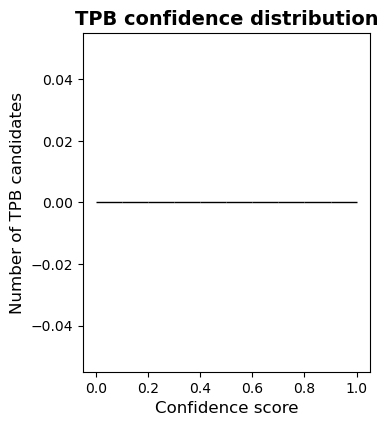

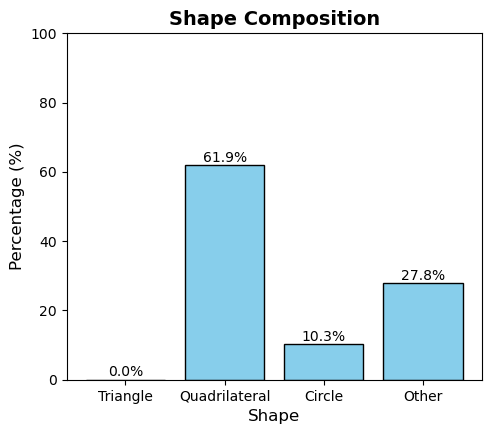

In [85]:
root = tk.Tk()
root.title("PEMFC TPB Recognition System")
root.geometry("1000x700")

# 创建一个固定尺寸的 content_frame，用于存放各页面内容
content_frame = tk.Frame(root, width=1000, height=700)
content_frame.pack(expand=True, fill="both")
content_frame.pack_propagate(False)  # 固定尺寸，不自动扩展

# 添加固定的 User Guide 按钮，始终显示在主窗口右上角
def show_user_guide():
    """显示弹出式 User Guide 窗口，提供应用使用说明。"""
    guide_win = tk.Toplevel(root)
    guide_win.title("User Guide")
    guide_win.geometry("400x300")
    guide_win.resizable(False, False)
    guide_text = (
        "Welcome to the PEMFC TPB Recognition System!\n\n"
        "1. Click 'Upload Image' to select an image file (JPG, PNG, etc.).\n"
        "2. The system processes the image and displays:\n"
        "   - The original image\n"
        "   - The processed image\n"
        "   - A histogram of TPB confidence distribution\n\n"
        "3. Navigate between pages using the navigation buttons at the bottom:\n"
        "   - Page 2: TPB Analysis Results\n"
        "   - Page 3: Morphology Analysis with annotated shapes and histogram\n"
        "   - Page 4: Reserved for further instructions\n\n"
        "4. A User Guide button is always available at the top right.\n"
        "5. For best results, use a clear, high-resolution image.\n\n"
        "Thank you for using our application!"
    )
    text_widget = tk.Text(guide_win, wrap="word", font=("Arial", 10), bg="white", bd=0)
    text_widget.insert("1.0", guide_text)
    text_widget.config(state="disabled")
    text_widget.pack(expand=True, fill="both", padx=10, pady=10)

user_guide_btn = tk.Button(root, text="User Guide", font=("Arial", 10, "bold"),
                           bg="#4a90e2", fg="white", activebackground="#357ABD", relief="raised", bd=2,
                           command=show_user_guide)
user_guide_btn.place(relx=0.95, rely=0.05, anchor="ne")

# 显示初始页面（Page 1）
show_page1()
root.mainloop()